In [1]:
# load and concatenate waverider data
import numpy as np
import  json
import datetime as dt
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4
import os
import pandas as pd
import scipy.io
from IPython.display import display, HTML
#from scipy import interpolate, signal
#from astropy.convolution import convolve, Gaussian1DKernel, Box1DKernel
%matplotlib inline

In [28]:
#dirname = r'D:'
dirname = r"D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels"
fname = '221p1_historic.nc'
fname2 = '221p1_rt.nc'
fpath = os.path.join(dirname,fname)
print(fpath)
ds = xr.open_dataset(fpath,decode_times=False)
print(ds['waveTime'])
fpath2 = os.path.join(dirname,fname2)
print(fpath2)
ds2 = xr.open_dataset(fpath2,decode_times=False)
print(ds2['waveTime'])

D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels\221p1_historic.nc
<xarray.DataArray 'waveTime' (waveTime: 24145)>
array([1463756865, 1463758665, 1463760465, ..., 1507214265, 1507216065,
       1507217865])
Coordinates:
  * waveTime              (waveTime) int32 1463756865 1463758665 1463760465 ...
    metaStationLatitude   float32 ...
    metaStationLongitude  float32 ...
Attributes:
    long_name:      UTC sample start time
    standard_name:  time
    units:          seconds since 1970-01-01 00:00:00 UTC
    calendar:       standard
    axis:           T
    bounds:         waveTimeBounds
    comment:        Spectral processing performed on 1600-second samples spec...
D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels\221p1_rt.nc
<xarray.DataArray 'waveTime' (waveTime: 18762)>
array([1507233825, 1507235625, 1507237425, ..., 1541793825, 1541795625,
       1541797425])
Coordinates:
  * waveTime             (waveTime) int32 1507233825 1507235625 1507237425 ...
    metaDeployL

#read in times with decode...results in datetime64 objects
#dirname = r'D:'
dirname = r"D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels"
fname = '221p1_historic.nc'
fname2 = '221p1_rt.nc'
fpath = os.path.join(dirname,fname)
print(fpath)
ds = xr.open_dataset(fpath,decode_times=True)
print(ds['waveTime'])
fpath2 = os.path.join(dirname,fname2)
print(fpath2)
ds2 = xr.open_dataset(fpath2,decode_times=True)
print(ds2['waveTime'])


In [3]:
# Rich's suggestion (generates error)
#ds3 = xr.open_mfdataset([fpath, fpath2])

In [4]:
print(ds)
print(ds2)

<xarray.Dataset>
Dimensions:                     (dwrTime: 24146, gpsTime: 23709, metaBoundsCount: 2, sourceCount: 1, sstTime: 24146, waveFrequency: 64, waveTime: 24145)
Coordinates:
  * waveTime                    (waveTime) datetime64[ns] 2016-05-20T15:07:45 ...
  * waveFrequency               (waveFrequency) float32 0.025 0.03 0.035 ...
  * sstTime                     (sstTime) datetime64[ns] 2016-05-20T15:36:45 ...
  * gpsTime                     (gpsTime) datetime64[ns] 2016-05-20T15:30:15 ...
  * dwrTime                     (dwrTime) datetime64[ns] 2016-05-20T15:07:45 ...
    metaStationLatitude         float32 ...
    metaStationLongitude        float32 ...
Dimensions without coordinates: metaBoundsCount, sourceCount
Data variables:
    sourceFilename              (sourceCount) object ...
    waveTimeBounds              (waveTime, metaBoundsCount) datetime64[ns] ...
    waveFlagPrimary             (waveTime) float32 ...
    waveFlagSecondary           (waveTime) float32 ...
    

### Concatenate the two parts of the time series
This is a manual way to do it, producing np arrays, and not taking advantage of dask.

In [32]:
# if imported with
# dtm64 =  np.concatenate( (ds['waveTime'].values, ds2['waveTime'].values) )
# if imported as seconds since 1970-01-01 00:00:00 UTC, add offset to convert to Matlab times 
dn = 719529.0 + 1./(24.*3600.) * np.concatenate( (ds['waveTime'].values, ds2['waveTime'].values) )
Hs = np.concatenate( (ds['waveHs'].values,   ds2['waveHs'].values )  )
Tp = np.concatenate( (ds['waveTp'].values,   ds2['waveTp'].values )  )
Ta = np.concatenate( (ds['waveTa'].values,   ds2['waveTa'].values )  )
Dp = np.concatenate( (ds['waveDp'].values,   ds2['waveDp'].values )  )

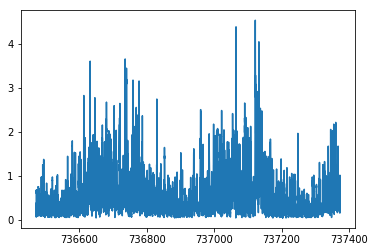

In [33]:
plt.plot(dn,Hs)

### Functions to convert between Matlab datenum and Python datetime


In [7]:
def matlabdn2datetime( dn ):
    """
    Convert array of matlab datenum floats to list of python datetime objects
    
    Inverse of datetime2matlabdn
    
    Input:
        dn - numpy array of matlab datenum floats   
    Returns:
        dtm - numpy array of datetime objects
        
    Requires:
        import datetime as dt
    
    https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python/13965852#13965852
    """
    # loop through and make a list of datetime objects
    dtm = [dt.datetime.fromordinal(int(d)-366 ) + dt.timedelta(days=d%1) for d in dn]
    
    # convert to numpy array
    return np.array(dtm)

def datetime2matlabdn(dtm):
    """
    Convert python datetime to matlab datenum 
    
    Inverse of matlabdn2datetime
    
    Input:
        dtm - numpy array of matlab datenums (floats)   
    Returns:
        dtm - numpy array of python datetime objects
        
    Requires:
        import datetime as dt
 
    https://stackoverflow.com/questions/8776414/python-datetime-to-matlab-datenum
    """
    dn = []
    for dtmi in dtm:
        ord = dtmi.toordinal()
        mdn = dtmi + dt.timedelta(days = 366)
        frac = (dtmi-dt.datetime(dtmi.year,dtmi.month,dtmi.day,0,0,0)).seconds / (24.0 * 60.0 * 60.0)
        dn.append( mdn.toordinal()+frac )
        
    # convert to numpy array
    return np.array(dn)

First time:  05/20/2016 15:07:45
Last time :  11/09/2018 21:03:44


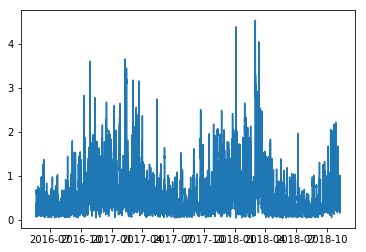

In [37]:
dtm = matlabdn2datetime( dn )
print("First time: ",'{:%m/%d/%Y %H:%M:%S}'.format(dtm[0]))
print("Last time : ",'{:%m/%d/%Y %H:%M:%S}'.format(dtm[-1]))
plt.plot(dtm,Hs)



### Load the Matlab data file of Sandwich water level that Alfredo made

In [8]:
wl_fpath = r"D:\crs\proj\2015_Sandwich\data_proc\waves_water_levels"
#wl_fpath = r"D:"
fpath3 = os.path.join(wl_fpath,'Sandwidch_WL_surgeplustide_lag.mat')

wlevels = scipy.io.loadmat(fpath3)
wl = np.squeeze(np.array(wlevels["sand_total"]))
T = np.squeeze(np.array(wlevels["T"]))

print("Type and shape of T: ",type(T),print(np.shape(T)))

# This is how we would convert to datetime, but instead, we will interpolate using Matlab datetimes
# dtime = matlabdn2datetime( T )
# # Good info on datetime formatting:
# # https://stackoverflow.com/questions/10624937/convert-datetime-object-to-a-string-of-date-only-in-python
# print("First time: ",'{:%m/%d/%Y %H:%M:%S}'.format(dtime[0]))
# print("Last time : ",'{:%m/%d/%Y %H:%M:%S}'.format(dtime[-1]))

(113857,)
Type and shape of T:  <class 'numpy.ndarray'> None


In [101]:
# Trim the wave file to end at same time as water-level file
dn=dn[np.where(dn<=T[-1])]
Hs=Hs[np.where(dn<=T[-1])]
Tp=Tp[np.where(dn<=T[-1])]
Ta=Ta[np.where(dn<=T[-1])]
Dp=Dp[np.where(dn<=T[-1])]
dtm=dtm[np.where(dn<=T[-1])]

In [102]:
# Now interpolate water level onto wave times
print(np.shape(T),np.shape(wl),np.shape(dn))
wli = np.interp( dn, T, wl )


(113857,) (113857,) (32347,)


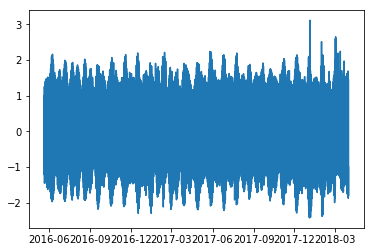

In [103]:
plt.plot(dtm,wli)




In [166]:
def calcR2(H, T, tanalpha, igflag=0):
    '''
    %
    % [R2,S,setup, Sinc, SIG, ir] = calcR2( H, T, tanalpha, igflag );
    %
    % Calculated 2% runup (R2), swash (S), setup (setup), incident swash (Sinc)
    % and infragravity swash (SIG) elevations based on parameterizations from runup paper
    % also Iribarren (ir)
    % August 2010 - Included 15% runup (R16) statistic that, for a Guassian distribution, 
    % represents mean+sigma. It is calculated as R16 = setup + swash/4.  
    % In a wave tank, Palmsten et al (2010) found this statistic represented initiation of dune erosion. 
    %
    %
    % H = significant wave height, reverse shoaled to deep water
    % T = deep-water peak wave period
    % tanalpha = rise/run [] of beach slope.  This is different than Hilary's original version
    % igflag = 0 (default)use full equation for all data
    %        = 1  use dissipative-specific calculations when dissipative conditions exist (Iribarren < 0.3)
    %        = 2  use dissipative-specific (IG energy) calculation for all data
    %
    % based on:
    %  Stockdon, H. F., R. A. Holman, P. A. Howd, and J. Sallenger A. H. (2006),
    %    Empirical parameterization of setup, swash, and runup,
    %    Coastal Engineering, 53, 573-588.
    % author: hstockdon@usgs.gov
    
    # converted from calcR2.m to Python by csherwood@usgs.gov
    # Differences from the Matlab version:
    # 1) This takes tan(alpha) as the slope argument, instead of alpha (radians)
    # 2) If only one value of tanalpha is given, all calcs will be made with the same slope
    # 3) Python version expects np.arrays. For a single value, pass it np.array([H]), np.array([T]), np.array([tanalpha])
    '''
    N = len(H)
    g = 9.81

    #  intialize output
    R2    = np.NaN*np.ones_like(H);
    R16   = R2.copy()
    S     = R2.copy()
    setup = R2.copy()
    Sinc  = R2.copy()
    SIG   = R2.copy()

    # make slopes positive!
    tanalpha = np.abs(tanalpha)
    
    if len(tanalpha) == 1:
        tanalpha =tanalpha*np.ones(N,)
    
    # convert slopes from rise/run to radians
    slope = np.arctan(tanalpha)

    # compute wavelength and Iribarren number
    L = (g*T**2.) / (2.*np.pi)
    ir = slope / np.sqrt(H/L)
    
    for ii in range(N): # have to do in loop to check Iribarren number
        if igflag == 2: # use dissipative equations (IG) for ALL data
            R2[ii]    = 1.1*( 0.039 * np.sqrt(H[ii]*L[ii]))
            S[ii]     = 0.046*np.sqrt(H[ii]*L[ii])
            setup[ii] = 0.016*np.sqrt(H[ii]*L[ii])

        elif igflag == 1 and ir(ii) < 0.3: # if dissipative site use diss equations
            R2[ii]    = 1.1*( 0.039 * np.sqrt(H[ii]*L[ii]))
            S[ii]     = 0.046*np.sqrt(H[ii]*L(ii))
            setup[ii] = 0.016*np.sqrt(H[ii]*L[ii])

        else: # if int/ref site, use full equations
            #  Coded as written in paper (equation 19)
            #         part1 = 0.35*slope(ii).*sqrt(H(ii).*L(ii));
            #         part2 = sqrt(H(ii).*L(ii).*( (0.5625*slope(ii).^2)+0.0036))/2;
            #         R2(ii) = 1.1*(part1+part2);
            setup[ii] = 0.35*slope[ii]*np.sqrt(H[ii]*L[ii])
            Sinc[ii]  = 0.75*slope[ii]*np.sqrt(H[ii]*L[ii])
            SIG[ii]   = 0.06*np.sqrt(H[ii]*L[ii])
            S[ii]     = np.sqrt(Sinc[ii]**2 + SIG[ii]**2)
            R2[ii]    = 1.1*(setup[ii] + S[ii]/2)
            R16[ii]   = 1.1*(setup[ii] + S[ii]/4)

    return R2, S, setup, Sinc, SIG, ir

print(np.arctan(0.005))
print(np.radians(4.5))
print(np.tan(np.radians(4.5)))
print(np.tan(np.radians(6.5)))
R2, S, setup, Sinc, SIG, ir = calcR2(np.array([2.]), np.array([10.]), np.array([0.1]), 0)
print('R2, S, setup, Sinc, SIG, ir',R2, S, setup, Sinc, SIG, ir)

0.00499995833396
0.0785398163397
0.0787017068246
0.113935608302
R2, S, setup, Sinc, SIG, ir [ 1.60967292] [ 1.69381113] [ 0.61643345] [ 1.32092883] [ 1.06025619] [ 0.88061922]


In [173]:
R2_15, S, setup, Sinc, SIG, ir = calcR2(Hs, Tp, np.array([0.15]), igflag=0)
print(R2_15)
R2_05, S, setup, Sinc, SIG, ir = calcR2(Hs, Tp, np.array([0.05]), igflag=0)
print(R2_05)

[ 0.1144556   0.31797844  0.26324788 ...,  0.40321127  0.39686111
  0.3694967 ]
[ 0.05237916  0.14551884  0.12047208 ...,  0.18452457  0.1816185
  0.16909552]


In [168]:
ne = Dp+10 <= 105

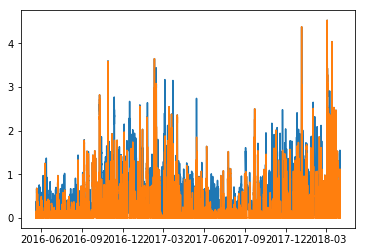

In [169]:
plt.plot(dtm,Hs)
plt.plot(dtm,Hs*ne)

In [181]:
dslist = ['Jan 4 2018']

for d in dslist:
    dstart =dt.datetime.strptime(d,'%b %d %Y')

# dstart = dt.datetime.strptime('Jan 4 2018  12:00PM', '%b %d %Y %I:%M%p')
# dend = dt.datetime.strptime('Jan 5 2018  12:00PM', '%b %d %Y %I:%M%p')

C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\IOOS3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in maximum
  This is separate from the ipykernel package so we can avoid doing imports until


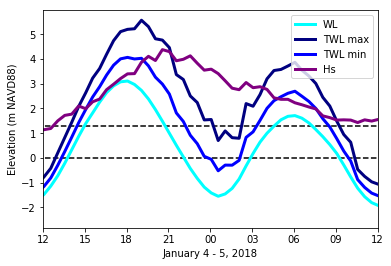

In [175]:
import matplotlib.dates as mdates

hw = np.maximum(wli+R2, np.zeros_like(wli))

fig, ax = plt.subplots()
mhw = 1.28*np.ones_like(wli)
mw = np.zeros_like(wli)

myFmt = mdates.DateFormatter('%H')

ax.plot(dtm,mhw,'--',color='black')
ax.plot(dtm,mw,'--',color='black')
ax.plot(dtm,wli,linewidth=3,label="WL",color="aqua")
ax.plot(dtm,wli+R2_15,linewidth=3,label="TWL max",color="navy")
ax.plot(dtm,wli+R2_05,linewidth=3,label="TWL min",color="blue")
ax.plot(dtm,Hs,linewidth=3,label="Hs",color="purple")
ax.set_xlim((dstart,dend))
ax.xaxis.set_major_formatter(myFmt)
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('January 4 - 5, 2018')

ax.legend()

df = pd.DataFrame(data=hw)
df.describe()
plt.savefig('Jan_4-5_water_levels.png',dpi=200)

In [178]:
wl_array = np.array([dn,Hs,Tp,wli,R2_05,R2_15])
print(np.shape(wl_array))
np.savetxt("wl_array.txt",wl_array,delimiter=",")

(6, 32347)


,0
count,32323.000000
mean,1.262142
std,0.522447
min,0.000000
25%,0.961954
50%,1.334477
75%,1.609776
max,3.686083


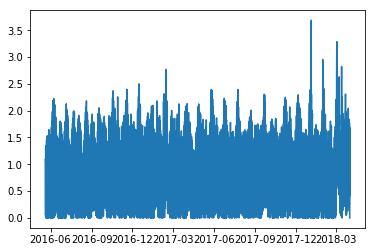

In [124]:
# sliding maxima
import scipy.ndimage
hwf=scipy.ndimage.maximum_filter(hw, size=(13), footprint=None, output=None, mode='reflect', cval=0.0, origin=0)
plt.plot(dtm,hwf)
df = pd.DataFrame(data=hwf)
df.describe()